In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
from scipy import spatial
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [2]:
import torch
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
%load_ext autoreload
%autoreload 2

# Load the dataset

In [5]:
scrna = sc.read('thesis/multigrate/data/hao-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 149926 × 27504
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'names', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [6]:
cite = sc.read('thesis/multigrate/data/hao-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 149926 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes'
    var: 'n_cells'
    uns: 'Batch_colors', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [7]:
scrna2 = sc.read('thesis/multigrate/data/sanger-2021/expressions-2.h5ad')
scrna2

AnnData object with n_obs × n_vars = 3475 × 23305
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [8]:
atac = sc.read('thesis/multigrate/data/sanger-2021/peaks_hvf-2.h5ad')
atac

AnnData object with n_obs × n_vars = 3475 × 40122
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'binary'

In [9]:
scrna3 = sc.read('thesis/multigrate/data/kotliarov-2020/expressions.h5ad')
scrna3

AnnData object with n_obs × n_vars = 52117 × 20245
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [10]:
cite3 = sc.read('thesis/multigrate/data/kotliarov-2020/protein.h5ad')
cite3

AnnData object with n_obs × n_vars = 52117 × 87
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

# Prep RNA-seq

In [11]:
len(set(scrna.var_names) & set(scrna2.var_names) & set(scrna3.var_names))

14234

In [12]:
common_genes = list(set(scrna.var_names) & set(scrna2.var_names) & set(scrna3.var_names))

In [13]:
scrna = scrna[:, common_genes]
scrna2 = scrna2[:, common_genes]
scrna3 = scrna3[:, common_genes]

In [14]:
scrna = scrna[:350]
cite = cite[:350]

In [15]:
scrna2 = scrna2[:400]
atac = atac[:400]

In [16]:
scrna3 = scrna3[:300]
cite3 = cite3[:300]

In [17]:
adata = scrna.concatenate(scrna2, scrna3)
adata

AnnData object with n_obs × n_vars = 1050 × 14234
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2'

In [18]:
adata.X = adata.layers['count']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [19]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [20]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 1050 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_co

In [21]:
adata1 = adata[adata.obs.batch == '0']
adata2 = adata[adata.obs.batch == '1']
adata3 = adata[adata.obs.batch == '2']

In [22]:
adata1.obs['cell_type'] = adata1.obs['celltype.l1']
cite.obs['cell_type'] = cite.obs['celltype.l1']

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [23]:
adata1.obs['celltype.l2'].astype('category').cat.categories

Index(['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD14 Mono',
       'CD16 Mono', 'CD4 CTL', 'CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive',
       'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM', 'Doublet', 'HSPC', 'MAIT',
       'NK', 'NK Proliferating', 'Plasmablast', 'Treg', 'cDC2', 'dnT', 'gdT',
       'pDC'],
      dtype='object')

# Prep ADT

In [26]:
cite3.var_names = [name.split('_')[0] for name in cite3.var_names]

In [27]:
common_protein = list(set(cite.var_names) & set(cite3.var_names))
len(common_protein)

59

In [28]:
cite = cite[:, common_protein]
cite3 = cite3[:, common_protein]

In [29]:
adata = cite.concatenate(cite3)
adata

AnnData object with n_obs × n_vars = 650 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [30]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [31]:
adata.X = adata.layers['count']
adata = clr_normalize_each_cell(adata)

In [32]:
cite1 = adata[adata.obs.batch == '0']
cite3 = adata[adata.obs.batch == '1']

# Rename cell types

In [33]:
adata1.obs.cell_type = adata1.obs.cell_type.astype('category')
adata2.obs.cell_type = adata2.obs.cell_type.astype('category')
adata3.obs.cell_type = adata3.obs.cell_type.astype('category')
cite.obs.cell_type = cite.obs.cell_type.astype('category')
cite3.obs.cell_type = cite3.obs.cell_type.astype('category')
atac.obs.cell_type = atac.obs.cell_type.astype('category')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [34]:
adata1.obs.cell_type.cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'], dtype='object')

In [35]:
adata2.obs.cell_type.cat.categories

Index(['Bcell Memory', 'Bcell Naive', 'CD14 IL1B Monocyte', 'CD14 Monocyte',
       'CD16 Monocyte', 'CD4', 'CD4 Naive', 'CD8 Effector', 'CD8 Naive',
       'Cycling', 'GD Tcell', 'ILC', 'MAIT', 'NK', 'Treg', 'cDC', 'pDC'],
      dtype='object')

In [36]:
adata3.obs.cell_type.cat.categories

Index(['B', 'CD4 memory T', 'CD4 naive', 'CD8 memory T', 'CD8 naive',
       'Classical monocytes and mDC', 'NK', 'Non-classical monocytes',
       'Unconventional T cells', 'pDC'],
      dtype='object')

In [37]:
new_adata2_cat = {
    'Bcell Memory': 'B', 
    'Bcell Naive': 'B', 
    'CD14 IL1B Monocyte': 'Mono', 
    'CD14 Monocyte': 'Mono',
    'CD16 Monocyte': 'Mono', 
    'CD4': 'CD4 T', 
    'CD4 Naive': 'CD4 T', 
    'CD8 Effector': 'CD8 T', 
    'CD8 Naive': 'CD8 T',
    'Cycling': 'other', 
    'GD Tcell': 'other T', 
    'ILC': 'other', 
    'MAIT': 'other T', 
    'NK': 'NK', 
    'Plasmablasts': 'other', 
    'Treg': 'other T',
    'cDC': 'DC',
    'pDC': 'DC'
}

In [38]:
new_adata3_cat = {
    'B': 'B', 
    'CD4 memory T': 'CD4 T',
    'CD4 naive': 'CD4 T',
    'CD8 memory T': 'CD8 T',
    'CD8 naive': 'CD8 T',
    'Classical monocytes and mDC': 'Mono', 
    'NK': 'NK', 
    'Non-classical monocytes': 'Mono',
    'Unconventional T cells': 'other T', 
    'pDC': 'DC'
}

In [39]:
new_cell_types_2 = [new_adata2_cat[name] for name in adata2.obs.cell_type]
new_cell_types_3 = [new_adata3_cat[name] for name in adata3.obs.cell_type]

In [40]:
adata2.obs['old_cell_type'] = adata2.obs['cell_type']
adata2.obs['cell_type'] = new_cell_types_2
adata2.obs['cell_type'] = adata2.obs['cell_type'].astype('category')
adata2.obs['cell_type'].cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'], dtype='object')

In [41]:
adata3.obs['old_cell_type'] = adata3.obs['cell_type']
adata3.obs['cell_type'] = new_cell_types_3
adata3.obs['cell_type'] = adata3.obs['cell_type'].astype('category')
adata3.obs['cell_type'].cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other T'], dtype='object')

In [42]:
atac.obs['old_cell_type'] = atac.obs['cell_type']
atac.obs['cell_type'] = new_cell_types_2
atac.obs['cell_type'] = atac.obs['cell_type'].astype('category')
atac.obs['cell_type'].cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'], dtype='object')

In [43]:
cite3.obs['old_cell_type'] = cite3.obs['cell_type']
cite3.obs['cell_type'] = new_cell_types_3
cite3.obs['cell_type'] = cite3.obs['cell_type'].astype('category')
cite3.obs['cell_type'].cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other T'], dtype='object')

# Configure and train the model

In [44]:
adata1

AnnData object with n_obs × n_vars = 350 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 

In [45]:
adata2

AnnData object with n_obs × n_vars = 400 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'old_cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2', 

In [46]:
adata3

AnnData object with n_obs × n_vars = 300 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'old_cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2', 

In [47]:
cite

AnnData object with n_obs × n_vars = 350 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type'
    var: 'n_cells'
    uns: 'Batch_colors', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [48]:
cite3

AnnData object with n_obs × n_vars = 300 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'old_cell_type'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [49]:
atac

AnnData object with n_obs × n_vars = 400 × 40122
    obs: 'nb_features', 'cell_type', 'old_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'binary'

In [50]:
atac = atac[:, :5000]
atac

View of AnnData object with n_obs × n_vars = 400 × 5000
    obs: 'nb_features', 'cell_type', 'old_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'binary'

In [51]:
del adata
del scrna
del scrna2
del scrna3

In [42]:
cite3.obsm['true_protein'] = cite3.X

In [55]:
adata1.write('thesis/multigrate/data/test/adata1.h5ad')
adata2.write('thesis/multigrate/data/test/adata2.h5ad')
adata3.write('thesis/multigrate/data/test/adata3.h5ad')
cite.write('thesis/multigrate/data/test/cite1.h5ad')
cite3.write('thesis/multigrate/data/test/cite3.h5ad')
atac.write('thesis/multigrate/data/test/atac.h5ad')

... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'Phase' as categorical
... storing 'Batch' as categorical
... storing 'cluster_level2' as categorical
... storing 'cluster_level3' as categorical
... storing 'sample' as categorical
... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'Phase' as categorical
... storing 'Batch' as categorical
... storing 'cluster_level2' as categorical
... storing 'cluster_level3' as categorical
... storing 'sample' as categorical
... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorica

In [4]:
adata1=sc.read('thesis/multigrate/data/test/adata1.h5ad')
adata2=sc.read('thesis/multigrate/data/test/adata2.h5ad')
adata3=sc.read('thesis/multigrate/data/test/adata3.h5ad')
cite=sc.read('thesis/multigrate/data/test/cite1.h5ad')
cite3=sc.read('thesis/multigrate/data/test/cite3.h5ad')
atac=sc.read('thesis/multigrate/data/test/atac.h5ad')

# models

In [268]:
model = mtg.models.MultiVAE_all_mod(
    adatas=[[adata1, adata2, adata3], [cite], [atac]],
    names=[['rna1', 'rna2', 'rna3'], ['cite1'], ['atac2']],
    pair_groups=[['pair1', 'pair2', 'pair3'], ['pair1'], ['pair2']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=15,
    h_dim=32,
    hiddens=[[], [], []],
    output_activations=['linear', 'linear', 'linear'],
    losses=['nb', 'mse', 'bce'],
    layers=[['count', 'count', 'count'], [None], ['binary']],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=1e-2,
    integ_coef=1e-2,
    cycle_coef=0,
    dropout=0.2
)

In [269]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[ 0.2891, -0.1324,  1.9476, -0.7716, -0.6517,  2.1936,  0.5341,  1.4720,
         -1.2647, -0.6203, -0.2579, -0.3192, -0.4903,  1.1106, -0.1938],
        [-2.3376, -0.4830,  0.5448, -0.9620,  0.0675,  1.0489,  1.2765,  1.0948,
          1.2495,  0.9483, -0.2358,  1.1153, -1.7148,  0.9262,  1.1923],
        [ 0.7337,  0.1096, -0.9243,  0.9675,  0.5934,  0.0720,  0.2120, -1.8944,
         -0.0945, -0.4535,  0.4153, -0.0643,  3.0502,  0.4481,  0.5228]],
       requires_grad=True)

In [270]:
1-spatial.distance.cosine(model.model.modality_vectors.weight[0].detach().numpy(),
                       model.model.modality_vectors.weight[1].detach().numpy())

0.2773539423942566

In [271]:
model.theta

tensor([[ 1.6387, -0.8286,  1.5714],
        [ 0.0808,  0.4609,  0.6210],
        [ 2.1580, -0.9298,  1.8923],
        ...,
        [ 0.9188, -0.1394,  1.3081],
        [-0.1183,  1.9011, -0.4136],
        [-1.2788, -0.5708,  0.7337]], requires_grad=True)

In [272]:
model.train(
    n_iters=100,
    #celltype_key='celltype.l1',
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=5000,
    validate_every=100,
    correct='all', #missing, none, all
    kernel_type='gaussian',
    version='2'
)

 |████████████████████| 100.0% iter=100/100, time=27.97(s), loss=3.1223, recon=3.1188, kl=8.9560, integ=0.2610, cycle=0.0000, val_loss=2.5652, val_recon=2.5596, val_kl=7.7564, val_integ=0.4014, val_cycle=0.0000

In [273]:
model.theta

tensor([[ 1.6125, -0.8581,  1.5449],
        [ 0.0886,  0.4333,  0.6006],
        [ 2.1804, -0.9542,  1.8677],
        ...,
        [ 0.8900, -0.1672,  1.2861],
        [-0.1410,  1.8737, -0.4398],
        [-1.2655, -0.5977,  0.7152]], requires_grad=True)

In [274]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[ 0.2670, -0.1584,  1.9252, -0.7753, -0.6254,  2.1730,  0.5332,  1.4944,
         -1.2806, -0.6229, -0.2510, -0.3450, -0.4612,  1.0960, -0.2121],
        [-2.3224, -0.5036,  0.5199, -0.9402,  0.0392,  1.0394,  1.2607,  1.0939,
          1.2377,  0.9579, -0.2549,  1.1103, -1.7426,  0.9102,  1.1749],
        [ 0.7114,  0.0840, -0.9475,  0.9627,  0.6218,  0.0531,  0.2039, -1.8724,
         -0.1192, -0.4574,  0.4234, -0.0901,  3.0695,  0.4342,  0.5028]],
       requires_grad=True)

In [275]:
1-spatial.distance.cosine(model.model.modality_vectors.weight[0].detach().numpy(),
                       model.model.modality_vectors.weight[1].detach().numpy())

0.27214235067367554

## Plot training history
Note that there's only one pair of datasets so we don't have the integration loss here.

In [276]:
model.history

,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_recon_zinb,train_recon_bce,train_kl,train_integ,train_cycle,...,cos_similarity_mod_vectors_1_2,mod_vec2_norm,val_loss,val_recon,val_recon_mse,val_recon_nb,val_recon_bce,val_kl,val_integ,val_cycle
0,99,3.122334,3.118848,1.185509,0.248601,0.0,0.714957,8.956042,0.261043,0.0,...,-0.552198,4.068015,2.565178,2.559628,0.752186,0.241824,0.646144,7.756441,0.4014,0


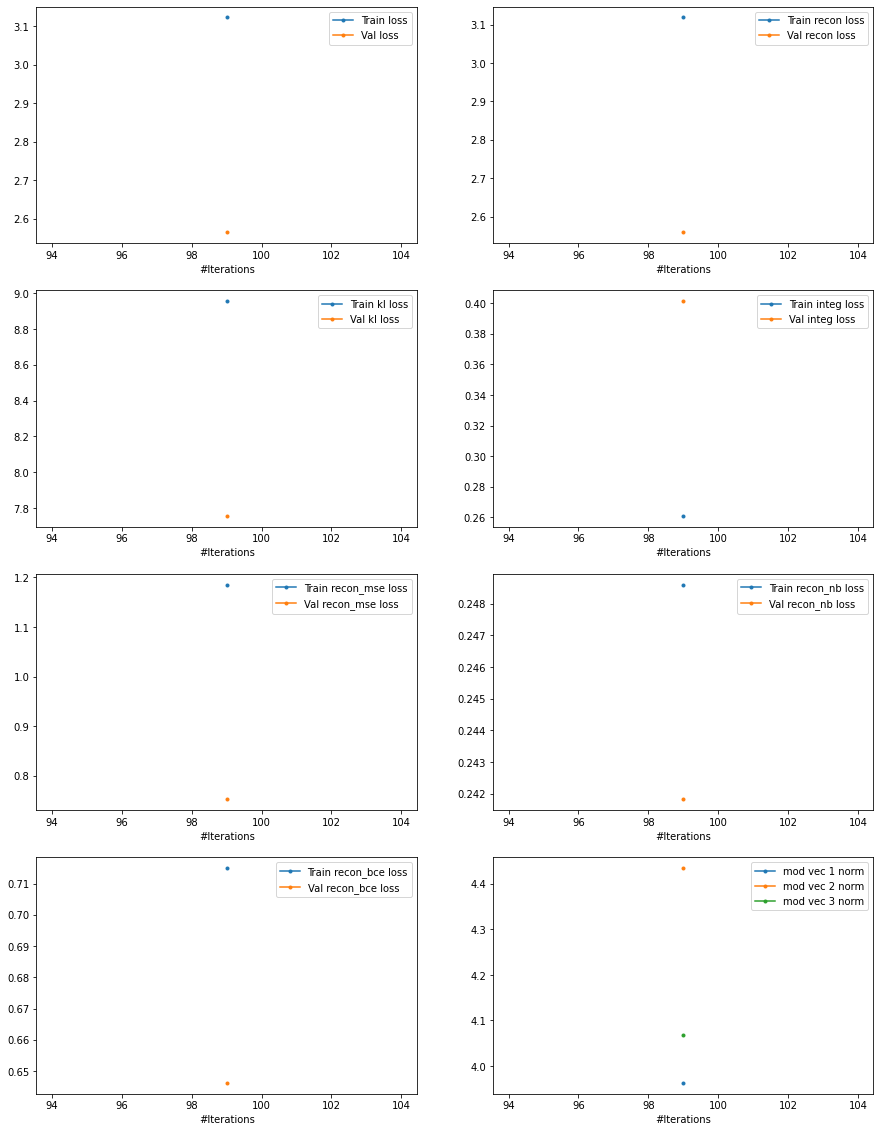

In [277]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_mse', 'recon_nb', 'recon_bce']
nrows = 4

plt.subplot(nrows, 2, 1)
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model.history['iteration'], model.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model.history['iteration'], model.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

plt.subplot(nrows, 2, nrows*2)
plt.plot(model.history['iteration'], model.history['mod_vec0_norm'], '.-', label='mod vec 1 norm');
plt.plot(model.history['iteration'], model.history['mod_vec1_norm'], '.-', label='mod vec 2 norm');
plt.plot(model.history['iteration'], model.history['mod_vec2_norm'], '.-', label='mod vec 3 norm');
plt.xlabel('#Iterations');
plt.legend()

# Validation

In [278]:
out = model.test(adatas=[[adata1, adata2, adata3], [cite], [atac]],
    names=[['rna1', 'rna2', 'rna3'], ['cite1'], ['atac2']],
    pair_groups=[['pair1', 'pair2', 'pair3'], ['pair1'], ['pair2']],
    layers=[['count', 'count', 'count'], [None], ['binary']],
    batch_size=64,
)

In [279]:
integrated, latent, corrected, hs = out

In [280]:
corrected

AnnData object with n_obs × n_vars = 1800 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [281]:
latent

AnnData object with n_obs × n_vars = 1050 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [282]:
hs

AnnData object with n_obs × n_vars = 1800 × 32
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [283]:
integrated

AnnData object with n_obs × n_vars = 1050 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [284]:
sc.pp.neighbors(corrected)
sc.tl.umap(corrected)

In [285]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

In [286]:
sc.pp.neighbors(hs)
sc.tl.umap(hs)

In [287]:
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

In [288]:
hs.obs['modality'] = hs.obs['modality'].astype('str')
hs.obs['batch'] = hs.obs['study'] + '-modality-' + hs.obs['modality']
hs.obs['modality'] = hs.obs['modality'].astype('category')
hs.obs['batch'] = hs.obs['batch'].astype('category')

In [289]:
corrected.obs['modality'] = corrected.obs['modality'].astype('str')
corrected.obs['batch'] = corrected.obs['study'] + '-modality-' + corrected.obs['modality']
corrected.obs['modality'] = corrected.obs['modality'].astype('category')
corrected.obs['batch'] = corrected.obs['batch'].astype('category')

In [290]:
latent.obs['modality'] = latent.obs['modality'].astype('str')
latent.obs['batch'] = latent.obs['study'] + '-modality-' + latent.obs['modality']
latent.obs['modality'] = latent.obs['modality'].astype('category')
latent.obs['batch'] = latent.obs['batch'].astype('category')

In [291]:
integrated.obs['modality'] = integrated.obs['modality'].astype('str')
integrated.obs['batch'] = integrated.obs['study'] + '-modality-' + integrated.obs['modality']
integrated.obs['modality'] = integrated.obs['modality'].astype('category')
integrated.obs['batch'] = integrated.obs['batch'].astype('category')

... storing 'study' as categorical
... storing 'cell_type' as categorical


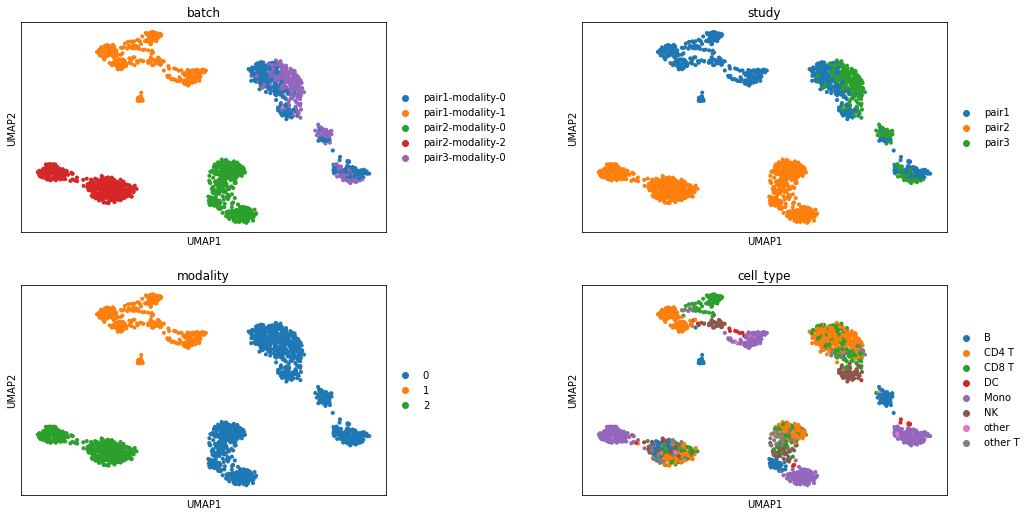

In [292]:
sc.pl.umap(hs, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

... storing 'study' as categorical
... storing 'cell_type' as categorical


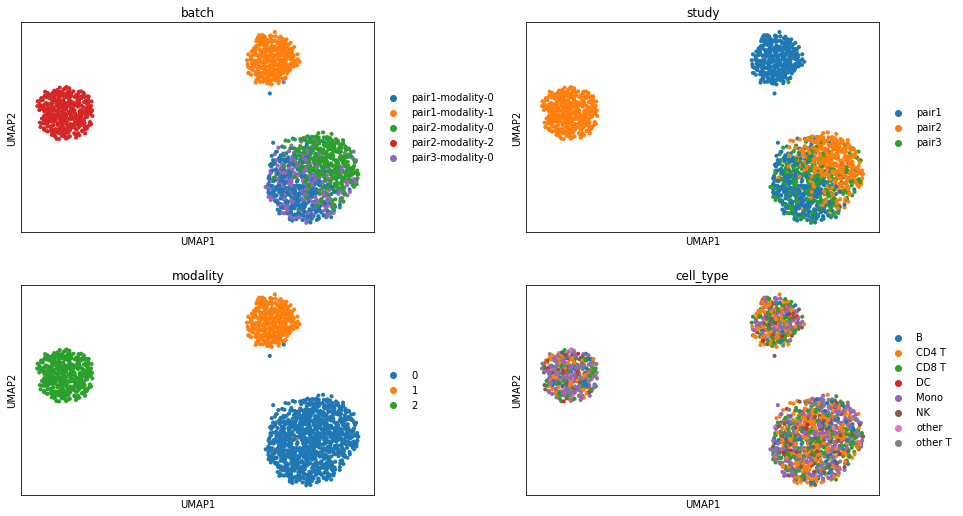

In [293]:
sc.pl.umap(corrected, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.3)

... storing 'study' as categorical
... storing 'cell_type' as categorical


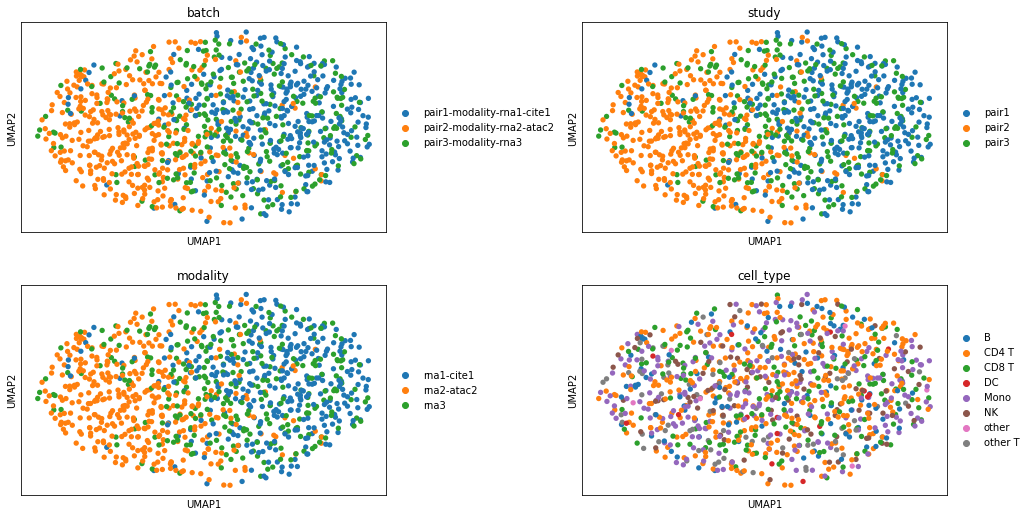

In [294]:
sc.pl.umap(latent, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

... storing 'study' as categorical
... storing 'cell_type' as categorical


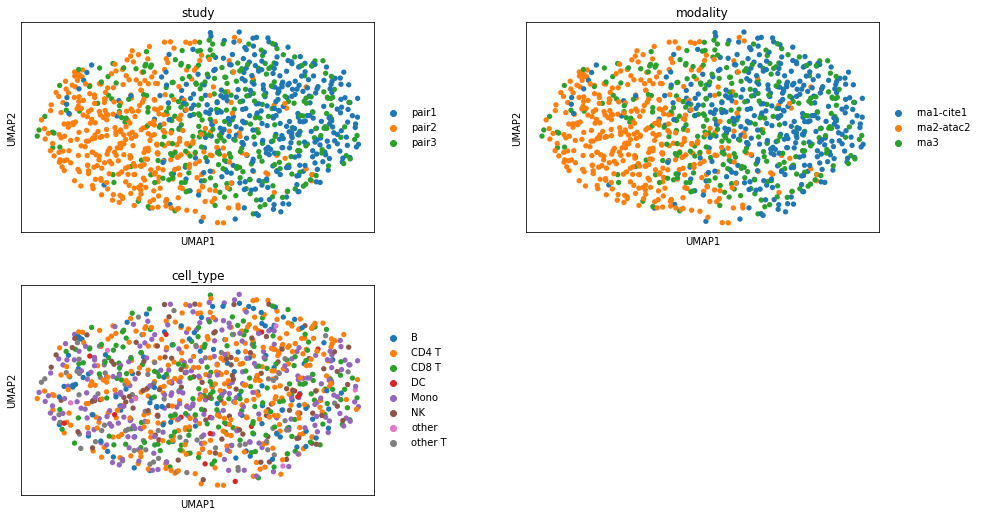

In [295]:
sc.pl.umap(integrated, color=['study', 'modality', 'cell_type'], ncols=2, wspace=0.3)

# impute

In [299]:
protein_pred = model.impute(
        adatas = [[adata3], []],
        names = [['rna3'], []],
        pair_groups = [['pair3'], []],
        target_modality = 1,
        batch_labels = [[2], []],
        target_pair = None,
        layers=[['count'], []],
        batch_size=64,
)

In [300]:
protein_pred.obsm['predicted_protein'] = protein_pred.X

In [301]:
protein_corrs = pd.DataFrame()
for i, protein in enumerate(cite3.var_names):
    value = np.round(pearsonr(protein_pred.obsm['predicted_protein'][:, i], cite3.obsm['true_protein'][:, i])[0], 3)
    protein_corrs = protein_corrs.append({'protein': protein, 'correlation': value}, ignore_index=True)
    
protein_corrs = protein_corrs.append({'protein': 'mean', 'correlation': protein_corrs['correlation'].mean().round(3)}, ignore_index=True)
protein_corrs = protein_corrs.set_index('protein')
protein_corrs

,correlation
protein,
CD45RO,-0.019
CD141,-0.006
CD86,-0.014
CD31,-0.131
CD163,0.086
CD134,0.044
CD57,0.046
CD185,-0.005
CD366,0.055


In [302]:
#protein_corrs.to_csv('test.csv')